In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# COLLECT AND PREPARE DATA

In [2]:
!cd ..
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [3]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [4]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [6]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [7]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [8]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

2023-12-08 15:05:12.815188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [11]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [12]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

2023-12-08 15:05:22.255027: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


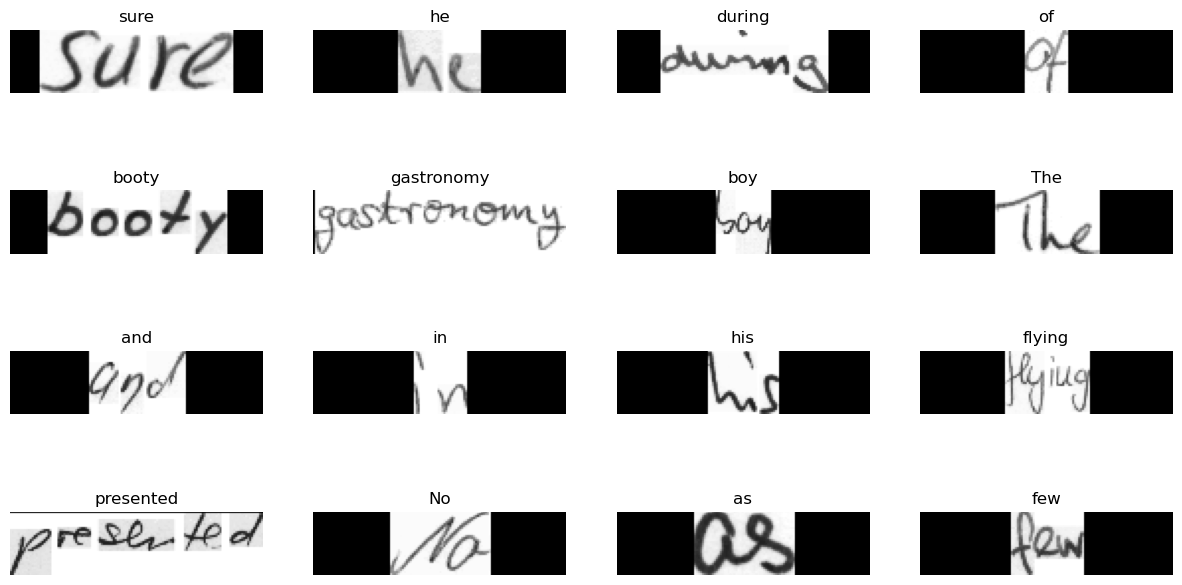

In [13]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [14]:
classes = ["the","of","and","a","to","in","is","you","that","it","he","was","for","on","are","as","with","his","they","I","at","be","this","have","from","or","one","had","by","word","but","not","what","all","were","we","when","your","can","said","there","use","an","each","which","she","do","how","their","if","will","up","other","about","out","many","then","them","these","so","some","her","would","make","like","him","into","time","has","look","two","more","write","go","see","number","no","way","could","people","my","than","first","water","been","call","who","oil","its","now","find","long","down","day","did","get","come","made","may","part"]
class2index = {word:ix for ix,word in enumerate(classes)}
index2class = {ix:word for ix,word in enumerate(classes)}

In [57]:
images_words = []
labels_words = []

for data in train_ds:
    images, labels = data["image"], data["label"]
    for i in range(len(images)):
        
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
    
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        if label in class2index:
            images_words.append(img)
            labels_words.append(class2index[label])
    

In [80]:
new_val_num = int(np.floor(0.20*len(images_words)))
new_val = images_words[:new_val_num]
new_val_label = labels_words[:new_val_num]


new_train = images_words[new_val_num:]
new_train_label = labels_words[new_val_num:]


# MODEL


In [171]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(3, (10, 10),activation='relu', input_shape=(32,128,1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(3, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(3, (3, 3),activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(100))

In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 23, 119, 3)        303       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 11, 59, 3)        0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 9, 57, 3)          84        
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 4, 28, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 2, 26, 3)          84        
                                                                 
 flatten_13 (Flatten)        (None, 156)             

In [173]:
new_train = np.asarray(new_train)
new_train_label = np.asarray(new_train_label)
new_val = np.asarray(new_val)
new_val_label = np.asarray(new_val_label)
history = model.fit(new_train, new_train_label, epochs=10, 
                    validation_data=(new_val, new_val_label))

Epoch 1/10
841/841 [==============================] - 16s 18ms/step - loss: 3.8900 - accuracy: 0.2507 - val_loss: 2.7974 - val_accuracy: 0.3386
Epoch 2/10
841/841 [==============================] - 16s 19ms/step - loss: 2.4928 - accuracy: 0.3898 - val_loss: 2.4590 - val_accuracy: 0.3934
Epoch 3/10
841/841 [==============================] - 16s 19ms/step - loss: 2.0341 - accuracy: 0.4730 - val_loss: 2.1524 - val_accuracy: 0.4601
Epoch 4/10
841/841 [==============================] - 16s 19ms/step - loss: 1.7440 - accuracy: 0.5342 - val_loss: 2.0517 - val_accuracy: 0.4891
Epoch 5/10
841/841 [==============================] - 16s 19ms/step - loss: 1.4991 - accuracy: 0.5850 - val_loss: 2.0953 - val_accuracy: 0.4936
Epoch 6/10
841/841 [==============================] - 16s 19ms/step - loss: 1.3067 - accuracy: 0.6308 - val_loss: 2.0637 - val_accuracy: 0.5092
Epoch 7/10
841/841 [==============================] - 16s 19ms/step - loss: 1.1255 - accuracy: 0.6699 - val_loss: 2.0897 - val_accuracy:

In [174]:
from tensorflow.keras.models import Model

intermediate_layer_index = 5
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[intermediate_layer_index].output)

In [215]:
to_arduino = new_val[400:800]
to_arduino_labels = new_val_label[400:800]

preds_arduino = intermediate_layer_model.predict(to_arduino)

13/13 [==============================] - 0s 5ms/step


In [216]:
preds_arduino.shape

(400, 156)

In [217]:
cpp_array = preds_arduino.tolist()

In [218]:
print(to_arduino_labels.tolist())

[4, 20, 27, 19, 22, 88, 0, 1, 0, 0, 3, 1, 84, 0, 13, 1, 0, 0, 30, 73, 2, 1, 28, 5, 53, 0, 50, 0, 19, 8, 0, 2, 61, 40, 2, 24, 65, 1, 32, 1, 62, 0, 27, 83, 9, 4, 40, 7, 25, 27, 0, 1, 13, 31, 1, 27, 4, 65, 61, 9, 13, 6, 0, 4, 50, 26, 0, 97, 5, 69, 11, 11, 20, 4, 0, 56, 5, 16, 12, 20, 28, 59, 3, 70, 84, 6, 24, 3, 0, 21, 3, 15, 54, 4, 42, 14, 8, 0, 0, 34, 98, 0, 27, 71, 10, 64, 0, 3, 14, 44, 2, 71, 0, 4, 17, 0, 2, 70, 86, 28, 0, 0, 13, 1, 0, 92, 9, 19, 19, 10, 2, 1, 17, 3, 8, 5, 74, 71, 17, 0, 12, 21, 34, 9, 2, 3, 9, 13, 23, 94, 11, 30, 30, 3, 84, 33, 78, 62, 27, 0, 11, 5, 15, 9, 21, 90, 84, 31, 1, 23, 93, 57, 23, 1, 70, 11, 0, 0, 19, 2, 76, 3, 4, 97, 49, 2, 2, 21, 5, 3, 15, 10, 0, 11, 84, 25, 6, 74, 8, 42, 2, 27, 6, 44, 68, 4, 3, 84, 10, 11, 2, 58, 6, 73, 57, 19, 5, 4, 5, 48, 1, 5, 0, 71, 0, 21, 0, 33, 9, 6, 52, 4, 19, 4, 0, 68, 4, 88, 2, 11, 16, 0, 0, 4, 28, 25, 6, 1, 11, 0, 1, 52, 1, 46, 82, 2, 15, 23, 0, 5, 2, 17, 38, 2, 10, 9, 12, 19, 5, 21, 13, 10, 0, 23, 2, 15, 44, 0, 5, 8, 78, 16, 1

In [219]:
print(cpp_array)

[[0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.8429995775222778, 0.8354548811912537, 2.9338483810424805, 0.6932051777839661, 2.2832326889038086, 11.665926933288574, 0.0, 0.0, 20.695411682128906, 0.0, 0.33087700605392456, 9.54123306274414, 0.0, 0.0, 0.0, 0.0, 12.123078346252441, 0.0, 0.11205446720123291, 2.6843948364257812, 0.0, 0.3050525188446045, 1.1859350204467773, 1.3492155075073242, 3.184044122695923, 0.11521317809820175, 0.0, 0.8019390106201172, 3.8659212589263916, 0.895715594291687, 0.0, 6.969831943511963, 7.063637733459473, 0.0, 9.5068941116333, 3.7499215602874756, 0.0, 1.4297809600830078, 0.0, 0.0, 4.280806064605713, 0.0, 0.6202050447463989, 0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.8429995775222778, 0.05849648267030716, 0.0, 0.842999577